<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F3D8F5;">

# What is the inhibitory connectivity underlying surround suppression in the mouse primary visual cortex?

## Background
Surround suppression is a feature of sensory processing which, in visual systems, facilitates the definition of objects against their backgrounds (Kiniklioglu & Kaiser, 2025) by sharpening receptive fields as suppression strength increases (Plomp et al., 2019). While much work has been directed to describing the functional aspect of surround suppression, the underlying inhibitory structural connectivity has received less attention. We propose the use of the V1DD dataset, which comprises both structural and functional data, to address several questions about the inhibitory connectivity subserving surround suppression across the layers of the mouse primary visual cortex. 
    
## Methods
### Feature extraction:
Morphological metrics: total axonal length/radius, branch counts, maximum branch order, output synapse counts, synaptic density per unit length, number of distinct target types, layer/radial distributions, soma depth
Activity metrics: Differences in ΔF/F for windowed gabor - full-field gabor, suppression index
Synapse spatial targeting: Comparison of SOM+ vs other inhibitory interneurons for probability of synapsing
    
## Statistics:
Make a null connectivity model (by shuffling connections between cells): If the cell is connected to the inhibitory cells, then this cell may be more functionally capable of doing surround suppression, and the cells that could have been connected to inhibitory cells, will be less capable. Whether this is actually the case is unclear, and making a null connectivity model will help with this question.
Spearman correlation for cell connectivity probabilities? Maybe could do paired tests, depends on the final form of data.


In [1]:
# Import packages
import sys
from os.path import join as pjoin
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from standard_transform.datasets import v1dd_ds

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)
from data_io import *
from utils import filter_synapse_table, check_index, adjacencyplot, calculate_lateral_distances
from data_io import _get_data_dir

In [2]:
# load the cell type information
ct_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

# Load synapses 
syn_df = syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

# Load the proofreading info
proofread_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# Mark proofread neurons in the synapse dataframe so we can filter out everything else
syn_df["pre_proofread"] = syn_df["pre_pt_root_id"].isin(proofread_ids)
syn_df["post_proofread"] = syn_df["post_pt_root_id"].isin(proofread_ids)

# These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.
layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  

In [3]:
# Convert from nanometers to microns
ct_df["soma_depth"] = (
    ct_df["pt_position_trform_y"] / 1_000
)  

ct_df.soma_depth.head()  # Approximate cell depth from pial surface in microns

0    549.910283
1    595.962276
2    203.770728
3    117.514626
4    475.075415
Name: soma_depth, dtype: float64

In [4]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:
ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [5]:
# Add proofreading information
ct_df["is_proofread"] = ct_df["pt_root_id"].isin(proofread_ids)
ct_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth,is_proofread
2,203262,624680,531094,283770,-252082.627894,203770.728235,21544.029756,864691132654552792,338.276613,E,L3-IT,203.770728,False
3,350562,894573,478559,163530,20989.259196,117514.626427,-98554.035375,864691132773514104,326.965400,E,L2-IT,117.514626,False
4,718122,1729859,674111,781200,803635.726721,475075.415268,467669.881328,864691132774106773,333.888647,None,None,475.075415,False
5,680726,1640231,677370,768015,713993.992148,475136.490033,454028.344107,864691132780109973,706.847075,None,None,475.136490,False
6,544582,1316562,974035,157590,334827.643688,613565.716183,-236450.684115,864691132736203675,200.069363,None,None,613.565716,False


In [6]:
# Add the synapse depth in consistent coordinates
syn_df["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df, projection="y"
)

syn_df.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342


In [41]:
# add the postsynaptic euclidean distance from the presynaptic cell/neuron

def add_euclidean_distance(df, x1='x1', x2='x2',y1='y1', y2='y2',z1='z1', z2='z2', new_col='distance'):
    """
    Calculate Euclidean distance from origin (0,0,0) for x, y, z coordinates in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing x, y, z coordinate columns.
    x_col, y_col, z_col : str
        Names of the columns for x, y, z coordinates.
    new_col : str
        Name of the new column to store distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    x_col = x1-x2
    y_col = y1-y2 
    z_col = z1-z2
    df[new_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    return df


In [45]:
def calculate_euclidean_distance(df, x1_col, y1_col, z1_col, x2_col, y2_col, z2_col, new_col="distance"):
    """
    Calculates the Euclidean distance between (x1, y1, z1) and (x2, y2, z2) for each row in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing coordinate columns.
    x1_col, y1_col, z1_col : str
        Column names for the first set of coordinates.
    x2_col, y2_col, z2_col : str
        Column names for the second set of coordinates.
    new_col : str, optional (default="distance")
        Name of the new column to store calculated distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    df[new_col] = np.sqrt(
        (df[x2_col] - df[x1_col])**2 +
        (df[y2_col] - df[y1_col])**2 +
        (df[z2_col] - df[z1_col])**2
    )
    return df

In [8]:
# copy the synapses dataframe
syn_df_ecldn = syn_df.copy()
syn_df_ecldn.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342


In [46]:
# compute the euclidean distance for each post_pt_root_id
syn_df_ecldn = calculate_euclidean_distance(syn_df_ecldn, x1_col ='post_pt_position_x', y1_col ='post_pt_position_y', z1_col='post_pt_position_z',
                                      x2_col='pre_pt_position_x', y2_col ='pre_pt_position_y', z2_col ='pre_pt_position_z',new_col='euclidean_distance')
syn_df_ecldn.head()

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth,euclidean_distance
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071,496.957242
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291,630.451584
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491,417.469532
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163,448.176751
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342,419.686168


In [47]:
type(syn_df_ecldn["pre_pt_root_id"])

pandas.core.series.Series

In [48]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses, summed synapse size, average euclidean distance.

connectivity_df = (
    syn_df_ecldn.query("pre_proofread and post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"),avg_eucl_dist=("euclidean_distance", "mean"))
    .reset_index()
)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,avg_eucl_dist
0,864691132534275418,864691132619649223,1,2620,537.226302
1,864691132534275418,864691132656860272,1,898,372.965266
2,864691132534275418,864691132659029623,3,3828,699.941197
3,864691132534275418,864691132663192644,1,4488,435.666914
4,864691132534275418,864691132663898692,1,1556,610.875765


In [49]:
# add the synaptic ratio - divide sum_size by number of synapses
connectivity_df["synaptic_ratio"] = connectivity_df["sum_size"]/connectivity_df["num_synapses"]
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,avg_eucl_dist,synaptic_ratio
0,864691132534275418,864691132619649223,1,2620,537.226302,2620.0
1,864691132534275418,864691132656860272,1,898,372.965266,898.0
2,864691132534275418,864691132659029623,3,3828,699.941197,1276.0
3,864691132534275418,864691132663192644,1,4488,435.666914,4488.0
4,864691132534275418,864691132663898692,1,1556,610.875765,1556.0


In [50]:
# Move column 'synaptic_ratio' to the fourth position
col = connectivity_df.pop('synaptic_ratio')
connectivity_df.insert(4, 'synaptic_ratio', col)
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist
0,864691132534275418,864691132619649223,1,2620,2620.0,537.226302
1,864691132534275418,864691132656860272,1,898,898.0,372.965266
2,864691132534275418,864691132659029623,3,3828,1276.0,699.941197
3,864691132534275418,864691132663192644,1,4488,4488.0,435.666914
4,864691132534275418,864691132663898692,1,1556,1556.0,610.875765


In [51]:
# Merge with the cell type dataframe

connectivity_ct_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

connectivity_ct_df.head(10)


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,537.226302,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,372.965266,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,699.941197,313.619432,E,L4-IT,349.799057,I,DTC
3,864691132534275418,864691132663192644,1,4488,4488.0,435.666914,313.619432,E,L4-IT,480.704383,E,L5-ET
4,864691132534275418,864691132663898692,1,1556,1556.0,610.875765,313.619432,E,L4-IT,623.202753,I,PTC
5,864691132534275418,864691132666054744,1,4965,4965.0,520.588359,313.619432,E,L4-IT,465.692836,E,L5-ET
6,864691132534275418,864691132689698824,1,1436,1436.0,376.517158,313.619432,E,L4-IT,420.092290,I,DTC
7,864691132534275418,864691132700001158,1,631,631.0,372.096090,313.619432,E,L4-IT,427.743622,E,L5-ET
8,864691132534275418,864691132714139653,1,270,270.0,724.477094,313.619432,E,L4-IT,480.999345,I,DTC
9,864691132534275418,864691132739485851,1,3425,3425.0,731.517744,313.619432,E,L4-IT,436.666528,E,L5-ET


In [52]:
# find I to E connections

connectivity_ct_IE = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E"')
connectivity_ct_IE.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
85,864691132536286810,864691132563376846,1,231,231.000000,361.977099,481.95328,I,DTC,534.001457,E,L5-NP
88,864691132536286810,864691132596046903,1,702,702.000000,246.639920,481.95328,I,DTC,448.928478,E,L5-ET
89,864691132536286810,864691132598805055,1,415,415.000000,604.341725,481.95328,I,DTC,167.400869,E,L2-IT
90,864691132536286810,864691132606072261,1,240,240.000000,332.265872,481.95328,I,DTC,420.578933,E,L5-NP
91,864691132536286810,864691132606660376,6,6121,1020.166667,516.558435,481.95328,I,DTC,415.773718,E,L5-ET


In [53]:
connectivity_ct_IE["cell_type_post"].value_counts()

cell_type_post
L3-IT    14818
L5-ET     7010
L2-IT     5910
L4-IT     4088
L5-IT     3107
L6-IT     1470
L6-CT     1173
L5-NP      500
Name: count, dtype: int64

In [54]:
connectivity_ct_IE["cell_type_pre"].value_counts()

cell_type_pre
DTC    17432
PTC    16885
STC     2613
ITC     1146
Name: count, dtype: int64

In [55]:
connectivity_ct_IE

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
85,864691132536286810,864691132563376846,1,231,231.000000,361.977099,481.953280,I,DTC,534.001457,E,L5-NP
88,864691132536286810,864691132596046903,1,702,702.000000,246.639920,481.953280,I,DTC,448.928478,E,L5-ET
89,864691132536286810,864691132598805055,1,415,415.000000,604.341725,481.953280,I,DTC,167.400869,E,L2-IT
90,864691132536286810,864691132606072261,1,240,240.000000,332.265872,481.953280,I,DTC,420.578933,E,L5-NP
91,864691132536286810,864691132606660376,6,6121,1020.166667,516.558435,481.953280,I,DTC,415.773718,E,L5-ET
...,...,...,...,...,...,...,...,...,...,...,...,...
91993,864691133311980112,864691132903371002,1,390,390.000000,765.637231,134.100507,I,ITC,241.313404,E,L3-IT
91994,864691133311980112,864691132925225513,1,234,234.000000,363.504333,134.100507,I,ITC,224.076075,E,L3-IT
91995,864691133311980112,864691132930886632,1,673,673.000000,327.048284,134.100507,I,ITC,535.923251,E,L5-ET
91996,864691133311980112,864691132931817448,1,963,963.000000,604.717165,134.100507,I,ITC,438.395845,E,L5-ET


In [72]:
# Count the number of each inhibtory presynaaptic cell type connection

# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_IE = (
    connectivity_ct_IE.groupby(["post_pt_root_id","cell_type_pre"])
    .agg(num_connections=("cell_type_pre", "count"))
    .reset_index()  
)

queried_connectivity_ct_IE.head()

,post_pt_root_id,cell_type_pre,num_connections
0,864691132534275418,DTC,19
1,864691132534275418,PTC,8
2,864691132534275418,STC,2
3,864691132534315610,DTC,29
4,864691132534315610,PTC,24


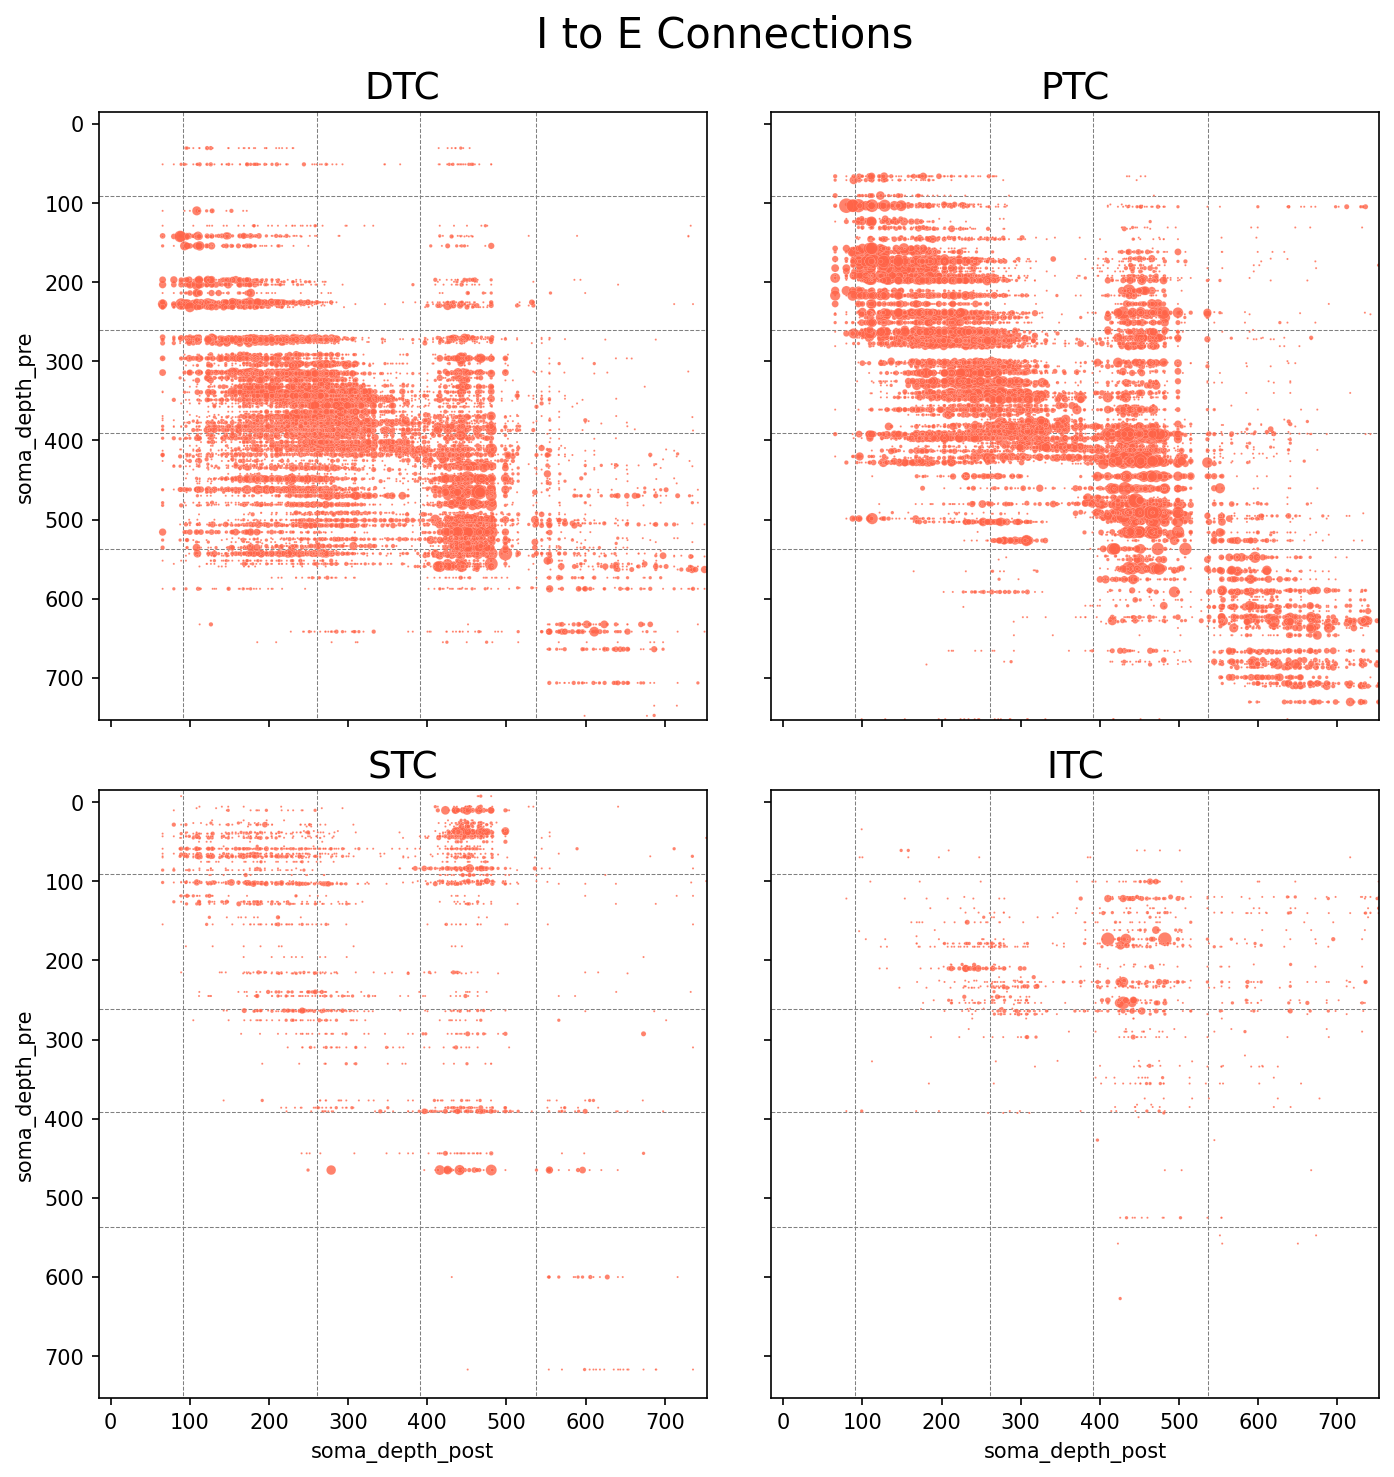

In [56]:
# visualize the IE synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ie_palette = {"I": "tomato", "E": "navy"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE.query(
                'cell_type_pre == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ie_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("I to E Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/structure/ItoE_synapticConnections.png")


In [58]:
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
np.array(ct_type).shape
print(ct_type[1][0])

STC


In [59]:
ct_type[pre_ind][post_ind]

'ITC'

In [60]:
# find E to I connections
connectivity_ct_EI = connectivity_ct_df.query('ei_pre == "E" and ei_post == "I"')
connectivity_ct_EI.head()


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,537.226302,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,372.965266,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,699.941197,313.619432,E,L4-IT,349.799057,I,DTC
4,864691132534275418,864691132663898692,1,1556,1556.0,610.875765,313.619432,E,L4-IT,623.202753,I,PTC
6,864691132534275418,864691132689698824,1,1436,1436.0,376.517158,313.619432,E,L4-IT,420.092290,I,DTC


In [61]:
len(connectivity_ct_EI)

19606

In [62]:
# count unique post_opt_root_ids
connectivity_ct_IE['post_pt_root_id'].value_counts()

post_pt_root_id
864691132669405014    172
864691132734343191    169
864691132688867336    160
864691132848998867    154
864691132830577529    151
                     ... 
864691132741048665      5
864691132786939218      4
864691132702645394      4
864691132781219967      2
864691132731452144      2
Name: count, Length: 674, dtype: int64

In [63]:
connectivity_ct_IE['post_pt_root_id'].unique()

array([864691132563376846, 864691132596046903, 864691132598805055,
       864691132606072261, 864691132606660376, 864691132608140569,
       864691132613539645, 864691132644003126, 864691132649386919,
       864691132655360252, 864691132656139260, 864691132657942744,
       864691132663192644, 864691132663800900, 864691132666054744,
       864691132669656346, 864691132670830031, 864691132672005146,
       864691132682319663, 864691132683942600, 864691132684814532,
       864691132685186469, 864691132685582532, 864691132689966614,
       864691132690620182, 864691132690646038, 864691132691044586,
       864691132692478968, 864691132695096809, 864691132710501931,
       864691132710866437, 864691132713507077, 864691132714014725,
       864691132717149199, 864691132720003059, 864691132725878426,
       864691132729719982, 864691132731780403, 864691132732388891,
       864691132734343191, 864691132739485851, 864691132741826140,
       864691132742621593, 864691132755400820, 864691132755677

In [65]:
# Keep only matching IDs
A,B = connectivity_ct_IE.copy(), connectivity_ct_EI.copy()

matching_root_ids = A[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]["post_pt_root_id"].unique()

print(len(matching_root_ids))
#print()
print("Matching IDs:", matching_root_ids)
#matching_root_ids.value_counts()

673
Matching IDs: [864691132563376846 864691132596046903 864691132598805055
 864691132606072261 864691132606660376 864691132608140569
 864691132613539645 864691132644003126 864691132649386919
 864691132655360252 864691132656139260 864691132657942744
 864691132663192644 864691132663800900 864691132666054744
 864691132669656346 864691132670830031 864691132672005146
 864691132682319663 864691132683942600 864691132684814532
 864691132685186469 864691132685582532 864691132689966614
 864691132690620182 864691132690646038 864691132691044586
 864691132692478968 864691132695096809 864691132710501931
 864691132710866437 864691132713507077 864691132714014725
 864691132717149199 864691132720003059 864691132725878426
 864691132729719982 864691132731780403 864691132732388891
 864691132734343191 864691132739485851 864691132741826140
 864691132742621593 864691132755400820 864691132755677300
 864691132759653483 864691132761554538 864691132761802292
 864691132762112606 864691132767824033 864691132772729

In [66]:
# index the matching IDs from postynaptic IE into EI connections
# thus  where IE post_pt_root_id == EI pre_pt_root_id 
# checking from EI unique connections to make sure there are 673 matching IDS

matching_root_ids = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]["pre_pt_root_id"].unique()
print(len(matching_root_ids))

connectivity_ct_IE_EI_mgd = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]
print(len(connectivity_ct_IE_EI_mgd))
connectivity_ct_IE_EI_mgd.head()

#B[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]

673
19606


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,537.226302,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,372.965266,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,699.941197,313.619432,E,L4-IT,349.799057,I,DTC
4,864691132534275418,864691132663898692,1,1556,1556.0,610.875765,313.619432,E,L4-IT,623.202753,I,PTC
6,864691132534275418,864691132689698824,1,1436,1436.0,376.517158,313.619432,E,L4-IT,420.092290,I,DTC


In [ ]:
# another way - not my favorite due to the duplication of information
# merge IE and EI dataframes where where IE post_pt_root_id == EI pre_pt_root_id 
connectivity_ct_IE_EI_mgd = pd.merge(connectivity_ct_IE, connectivity_ct_EI,
                                        left_on='post_pt_root_id', right_on='pre_pt_root_id')
 
print(len(connectivity_ct_IE_EI_mgd))
connectivity_ct_IE_EI_mgd.head()


In [67]:
connectivity_ct_IE_EI_mgd.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'num_synapses', 'sum_size',
       'synaptic_ratio', 'avg_eucl_dist', 'soma_depth_pre', 'ei_pre',
       'cell_type_pre', 'soma_depth_post', 'ei_post', 'cell_type_post'],
      dtype='object')

In [68]:
connectivity_ct_IE_EI_mgd["cell_type_pre"].value_counts()

cell_type_pre
L3-IT    6958
L2-IT    3426
L5-IT    2912
L4-IT    2700
L5-ET    1655
L6-IT     953
L5-NP     555
L6-CT     447
Name: count, dtype: int64

In [69]:
connectivity_ct_IE_EI_mgd["cell_type_post"].value_counts()

cell_type_post
DTC    9065
PTC    8682
ITC    1117
STC     742
Name: count, dtype: int64

In [73]:
# Count the number of each inhibtory postsynaaptic cell type connection

# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_EI = (
    connectivity_ct_IE_EI_mgd.groupby(["pre_pt_root_id","cell_type_post"])
    .agg(num_connections=("cell_type_post", "count"))
    .reset_index()  
)

queried_connectivity_ct_EI.head()

,pre_pt_root_id,cell_type_post,num_connections
0,864691132534275418,DTC,10
1,864691132534275418,PTC,5
2,864691132534275418,STC,1
3,864691132534315610,DTC,14
4,864691132534315610,ITC,3


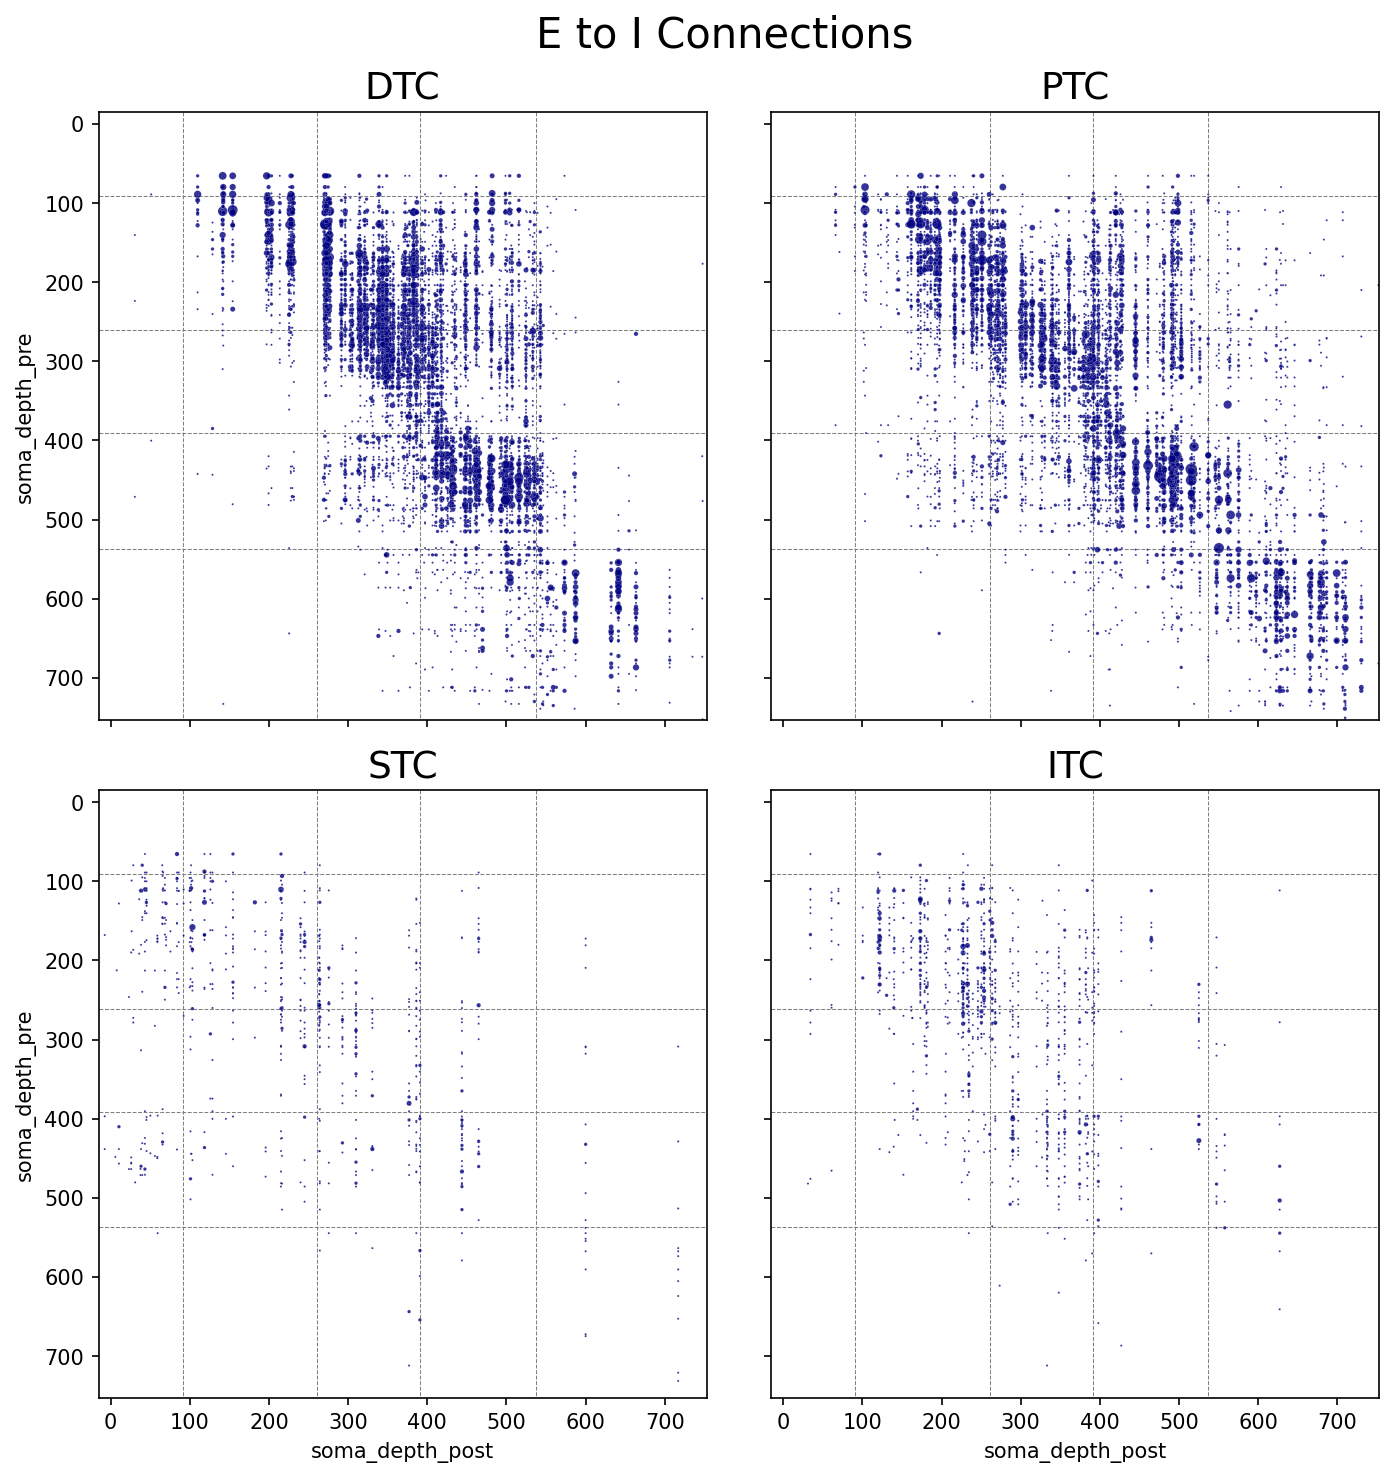

In [38]:
# visualize the EI synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ei_palette = {"E": "navy", "I": "tomato"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE_EI_mgd.query(
                'cell_type_post == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ei_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("E to I Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/structure/EtoI_synapticConnections.png")
